In [1]:
import os
import re
import numpy as np
import pandas as pd
import csv
import nltk
import torch

from tqdm import tqdm
import matplotlib.pyplot as plt


In [8]:
import matplotlib.pyplot as plt
import numpy as np
acclist = []
losslist = [0.67, 0.78, 0.93]

plt.plot([i for i in range(len(losslist))], losslist, 'r')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.savefig(str(max(acclist))+'loss.jpg')

plt.figure()

plt.plot([i for i in range(len(acclist))], acclist, 'b')
plt.xlabel('iterations')
plt.ylabel('acc')
plt.ylim((0.6, 1.1))
plt.savefig(str(max(acclist))+'acc.jpg')
plt.show()

ValueError: max() arg is an empty sequence

In [4]:
def load_data(filepath):
    labels = []
    texts = []
    with open(filepath, 'r') as f:
        cr = csv.DictReader(f)
        for row in cr:
            labels.append(int(row['Class Index'])-1)
            texts.append(row['Title'].lower().strip()
            +' [<sep>] '
            +row['Description'].lower().strip())
    return labels, texts
            

In [5]:
labels, texts = load_data('data/dev.csv')

In [6]:
maxlen = 0
minlen = 10000
for s in texts:
    maxlen = max(maxlen, len(s))
    minlen = min(minlen, len(s))
print(maxlen, minlen)

1003 108


In [7]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
device = torch.device("cpu")

In [9]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

In [10]:
def tokenize(sents):
    max_len = 0
    tokenized_sents = []
    wd2idx = {}
    wd2idx['<pad>'] = 0
    wd2idx['<unk>'] = 1
    idx = 2
    for sent in sents:
        tokenized_sent = word_tokenize(sent)
        max_len = max(max_len, len(tokenized_sent))
        tokenized_sents.append(tokenized_sent)
        for token in tokenized_sent:
            if token not in wd2idx:
                wd2idx[token] = idx
                idx += 1
    return tokenized_sents, wd2idx, max_len

In [11]:
def encode(tokenized_sents, wd2idx, max_len):
    input_ids = []
    for tokenized_sent in tokenized_sents:
        tokenized_sent += ['<pad>']*(max_len - len(tokenized_sent))
        input_id = [wd2idx[token] for token in tokenized_sent]
        input_ids.append(input_id)
    return np.array(input_ids)

In [12]:
from tqdm import  tqdm_notebook

In [13]:
def load_prevec(wd2idx, filepath):
    fprevec = open(filepath, 'r')
    dim = int(fprevec.readline().split()[1])
    embeddings = np.random.uniform(-0.25, 0.25, (len(wd2idx), dim))
    count = 0
    for wdembd in tqdm_notebook(fprevec):
        wd = wdembd.rstrip().split(' ')[0]
        embd = wdembd.rstrip().split(' ')[1:]
        if wd in wd2idx:
            count += 1
            embeddings[wd2idx[wd]] = np.array(embd, dtype=np.float32)
    print(count)
    print(len(wd2idx))
    return embeddings

In [29]:
tokenized_sents, wd2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_sents, wd2idx, max_len)
embeddings = load_prevec(wd2idx, '../fastText/crawl-300d-2M.vec')
embeddings = torch.tensor(embeddings)


23078
27798


In [30]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler)

In [31]:
def data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=64):
    train_inputs, val_inputs, train_labels, val_labels =  tuple(torch.tensor(data) for data in [train_inputs, val_inputs, train_labels, val_labels])
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.1, random_state=42)
train_dataloader, val_dataloader = data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=64)

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [35]:
class CNN_TCLF(nn.Module):
    def __init__(self
                ,pretrained_embedding=None
                ,freeze_embedding=False
                ,vocab_size=None
                ,embed_dim=300
                ,filter_sizes=[3, 4, 5]
                ,num_filters=[100, 100, 100]
                ,num_classes=4
                ,dropout=0.5):
        super(CNN_TCLF, self).__init__()
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size, 
                                            embedding_dim=self.embed_dim, 
                                            padding_idx=0, 
                                            max_norm=5.0)
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels=self.embed_dim, out_channels=num_filters[i], kernel_size=filter_sizes[i]) for i in range(len(filter_sizes))])
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids):
        x_embed = self.embedding(input_ids).float()
        x_reshaped = x_embed.permute(0, 2, 1)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list]
        x_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)
        logits = self.fc(self.dropout(x_fc))
        return logits



In [36]:
class LSTM_TCLF(nn.Module):
    def __init__(self
                ,pretrained_embedding=None
                ,freeze_embedding=False
                ,vocab_size=None
                ,hidden_size=200
				,bidirectional=True
                ,embed_dim=300
                ,num_classes=4
                ,dropout=0.5):

        super(LSTM_TCLF, self).__init__()
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embed_dim, padding_idx=0, max_norm=5.0)


        self.lstm = nn.LSTM(input_size=self.embed_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)
        self.drop = nn.Dropout(p=dropout)

        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)


        return text_out

In [37]:
# todo batch padding and form

In [38]:
import torch.optim as optim

In [39]:
def initilize_model(
    pretrained_embedding=None,
    freeze_embedding=False,
    vocab_size=None,
    embed_dim=300,
    filter_sizes=[3, 4, 5],
    num_filters=[100, 100, 100],
    num_classes=4,
    dropout=0.5,
    learning_rate=0.01
):
    cnn_model = CNN_TCLF(
        pretrained_embedding=pretrained_embedding,
        freeze_embedding=freeze_embedding,
        embed_dim=embed_dim,
        filter_sizes=filter_sizes,
        num_filters=num_filters,
        num_classes=num_classes,
        dropout=dropout
    )
    cnn_model.to(device)
    optimizer = optim.Adadelta(
        cnn_model.parameters(),
        lr=learning_rate,
        rho=0.95
    )
    return cnn_model, optimizer

In [40]:
def initilize_lstm_model(
    pretrained_embedding=None,
    freeze_embedding=False,
    vocab_size=None,
    embed_dim=300,
    filter_sizes=[3, 4, 5],
    num_filters=[100, 100, 100],
    num_classes=4,
    dropout=0.5,
    learning_rate=0.01
):
    cnn_model = CNN_TCLF(
        pretrained_embedding=pretrained_embedding,
        freeze_embedding=freeze_embedding,
        embed_dim=embed_dim,
        filter_sizes=filter_sizes,
        num_filters=num_filters,
        num_classes=num_classes,
        dropout=dropout
    )
    cnn_model.to(device)
    optimizer = optim.Adadelta(
        cnn_model.parameters(),
        lr=learning_rate,
        rho=0.95
    )
    return cnn_model, optimizer

In [52]:
model = LSTM_TCLF(
            pretrained_embedding=embeddings, 
            freeze_embedding=False,
            embed_dim=300,
            vocab_size=10000,
            hidden_size=64,
            bidirectional=True,
            num_layers=2,
            num_classes=4,
            dropout=0.5
        )

TypeError: __init__() got an unexpected keyword argument 'num_layers'

In [41]:
import random
import time
from tqdm import tqdm

In [42]:
loss_fn = nn.CrossEntropyLoss()
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [43]:
def train(model, optimizer, train_dataloader, val_dataloader=None, epochs=10):
    best_acc = 0
    for epoch_i in range(epochs):
        t_start = time.time()
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader):
            b_input_ids, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()
            logits = model(b_input_ids)
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_train_loss = total_loss / len(train_dataloader)
        if val_dataloader is not None:
            val_loss, val_acc = evaluate(model, val_dataloader)
            if val_acc > best_acc:
                best_acc = val_acc
            time_elapsed = time.time() - t_start
            print(f'epoch: {epoch_i}/{epochs} | avg_train_loss: {avg_train_loss} | val_loss: {val_loss} | val_acc: {val_acc} | best_acc: {best_acc} | time: {time_elapsed}')

    print('\n')
    print(f'Training complete. Best acc = {best_acc:.3f}%.')



In [44]:
def evaluate(model, val_dataloader):
    model.eval()
    val_acc = []
    val_loss = []
    for batch in tqdm(val_dataloader):
        b_input_ids, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits = model(b_input_ids)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1).flatten()
        acc = (preds == b_labels).cpu().numpy().mean()*100
        val_acc.append(acc)
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)
    return val_loss, val_acc

In [45]:
set_seed(42)
cnn_non_static, optimizer = initilize_model(pretrained_embedding=embeddings, freeze_embedding=False, learning_rate=0.25, dropout=0.5)

In [46]:
print(cnn_non_static)

CNN_TCLF(
  (embedding): Embedding(27798, 300)
  (conv1d_list): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [74]:
train(cnn_non_static, optimizer, train_dataloader, val_dataloader, epochs=1)

100%|██████████| 19/19 [00:00<00:00, 175.63it/s]epoch: 0/1 | avg_train_loss: 0.7174628960439958 | val_loss: 0.3106379924636138 | val_acc: 91.37260765550239 | best_acc: 91.37260765550239 | time: 2.982715129852295


Training complete. Best acc = 91.373%.



In [63]:
def predict(text, model=cnn_non_static.to('cpu'), max_len=62):
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>']*(max_len - len(tokens))
    input_id = [wd2idx.get(token, wd2idx['<unk>']) for token in padded_tokens]
    input_id = torch.tensor(input_id).unsqueeze(dim=0)
    logits = model.forward(input_id)
    probs = F.softmax(logits, dim=1).squeeze(dim=0)
    print(f'P: {probs}')

In [66]:
predict('Intel stock up on positive 4Q outlook [sep] Intel Corp. #39;s shares climbed nearly 6 percent Friday after saying its fourth-quarter sales are on track to break a company record because demand for the chips that ')

P: tensor([0.0110, 0.0066, 0.8659, 0.1165], grad_fn=<SqueezeBackward1>)


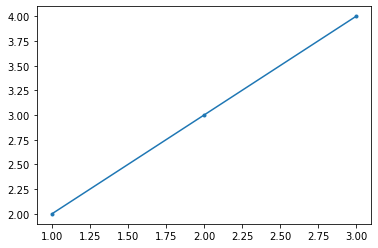

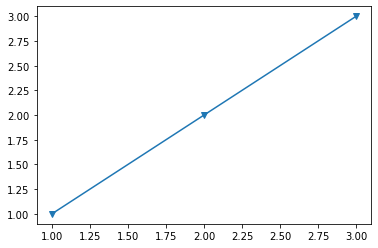

In [3]:
from matplotlib import pyplot as plt
x1=[1, 2, 3]
y1 = [2, 3, 4]
y2=[1, 2, 3]

plt.plot(x1,y1,marker=".")

plt.figure()
plt.plot(x1,y2,marker="v")
plt.show()


In [1]:
from tqdm import  tqdm_notebook
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from collections import defaultdict
import csv
import re
import numpy as np
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset)
from sklearn.model_selection import train_test_split

def load_data(filepath):
    labels = []
    texts = []
    htmlstr = re.compile('&lt.*?&gt;')
    with open(filepath, 'r') as f:
        cr = csv.DictReader(f)
        for row in cr:
            labels.append(int(row['Class Index'])-1)
            text = (row['Title'].lower().strip()
            +' [<sep>] '
            +row['Description'].lower().strip())
            text = re.sub(htmlstr, ' ', text)
            text = text.replace('\\', ' ')
            texts.append(text)
    return labels, texts

In [3]:
g, _ = load_data('data/dev.csvre')
p, _ = load_data('data/dev.csv')

In [4]:
g[:4]

[3, 1, 0, 0]

In [5]:
c = 0
for gg, pp in zip(g, p):
    if gg == pp:
        c += 1

In [6]:
c/len(g)

0.9213531015678255

In [14]:
# 分类报告：precision/recall/fi-score/均值/分类个数
from sklearn.metrics import classification_report
target_names = ['no', 'yes']
print(classification_report(gold, close, target_names=target_names, digits=4))


              precision    recall  f1-score   support

          no     0.7059    0.3317    0.4513       398
         yes     0.6728    0.9086    0.7731       602

    accuracy                         0.6790      1000
   macro avg     0.6893    0.6201    0.6122      1000
weighted avg     0.6860    0.6790    0.6450      1000



In [13]:
f=open('data/result_open.txt')
gold = [int(x) for x in f.readlines()]
f = open('data/result_close.txt')
close = [int(x) for x in f.readlines()]

In [8]:
len(gold)

3270

In [9]:
sum(gold)

2033

In [10]:
2033/3270

0.6217125382262997